In [1]:
#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline
#datapreparation
import os
import scipy.io as sio
import cv2
import PIL
#pytorch
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.autograd import Variable

## SURREAL DATASET

In [2]:
dirr_train = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0'
dirr_test = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0'
dirr_val = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0'

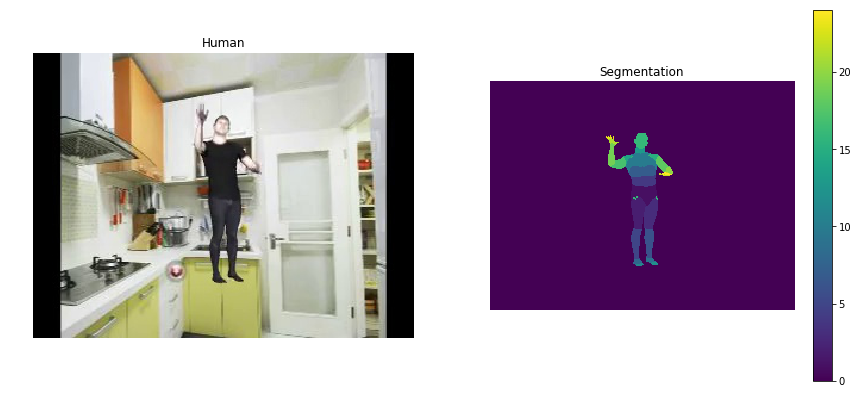

In [3]:
demonstrate_pic = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002frame1.jpg'
demonstrate_map = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0/143_20/143_20_c0002_segm.mat')['segm_1']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(demonstrate_pic))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_map)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

In [4]:
demonstrate_map < 20

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [6]:
def show_pics(imgs, col, row):
    fig = plt.figure(figsize=(5*col,5*row))
    for i in range(0, col*row):
        fig.add_subplot(row, col, i + 1)
        plt.imshow(imgs[i])
        plt.title('Class ' + str(i+1))
        plt.axis("off")

In [7]:
demonstrate_classes = np.zeros((25, 256, 320))
        
for i in range(len(demonstrate_map)):
    row = demonstrate_map[i]
    for j in range(len(row)):
        demonstrate_classes[row[j], i, j] = 1.0

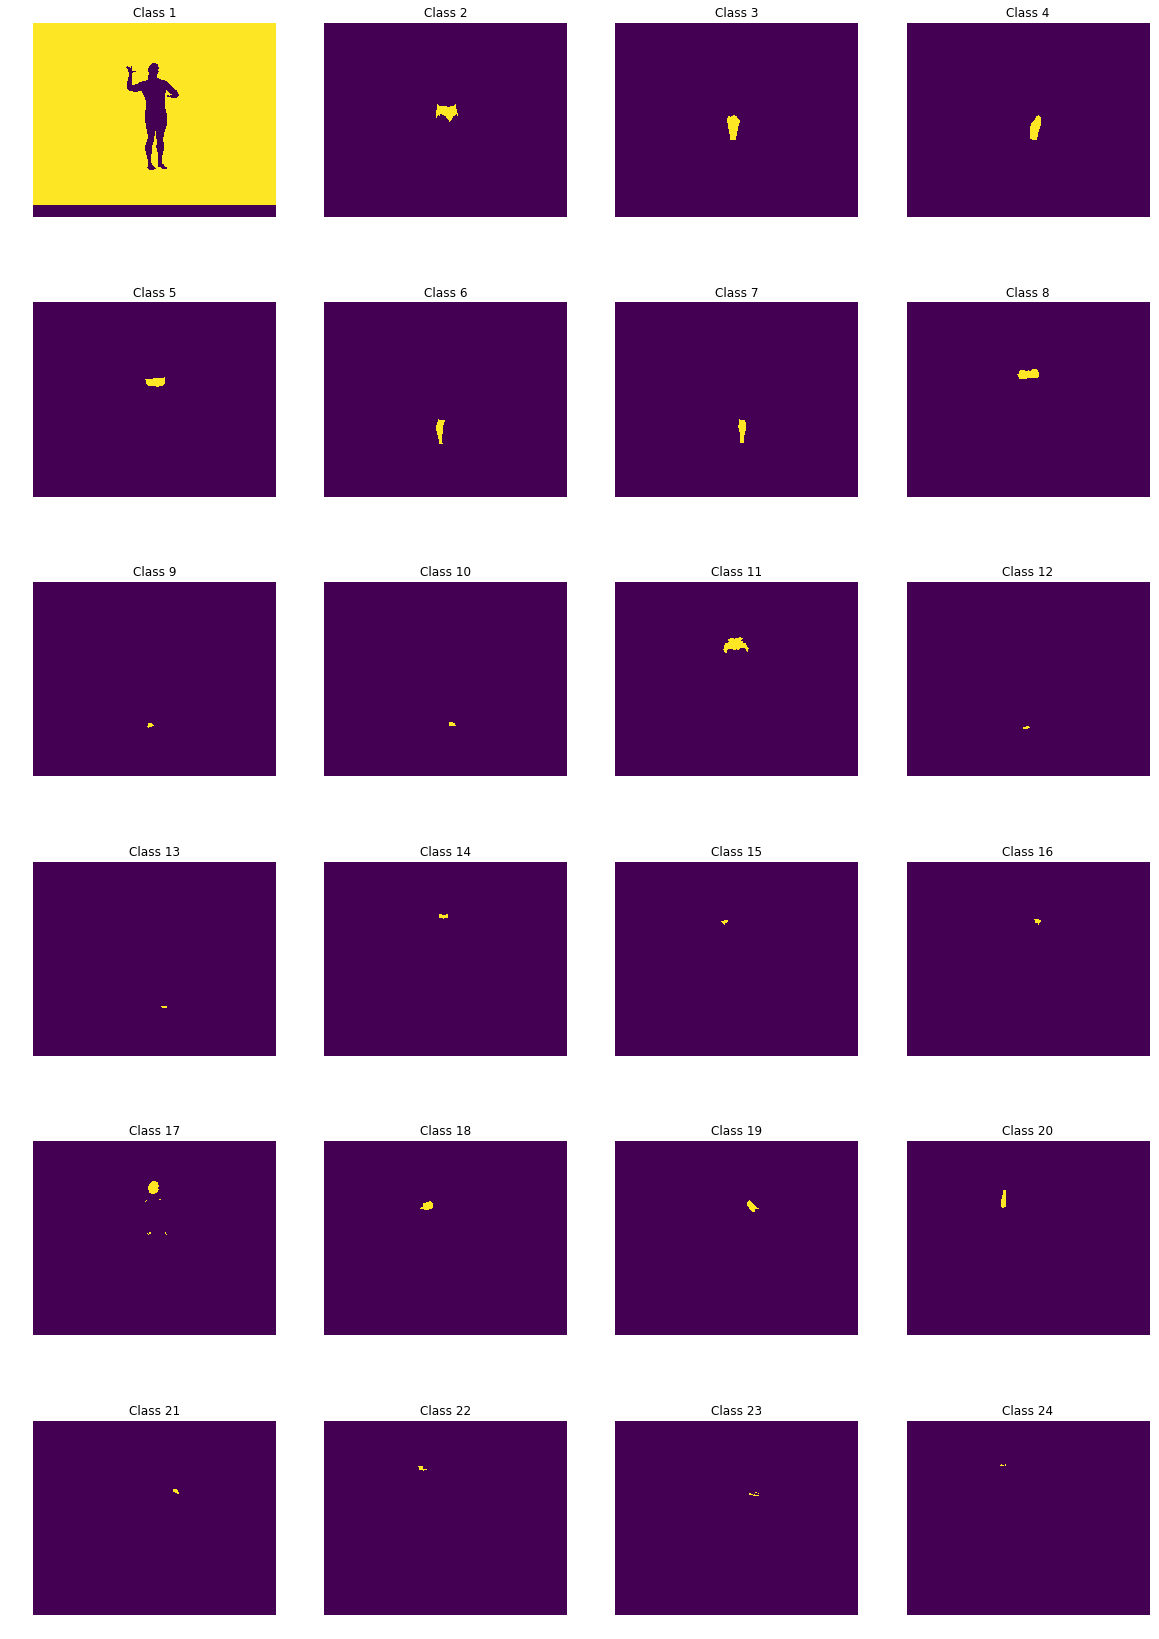

In [8]:
show_pics(demonstrate_classes, 4, 6)

## SITTING PEOPLE DATASET

In [9]:
sitting_dirr = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img'

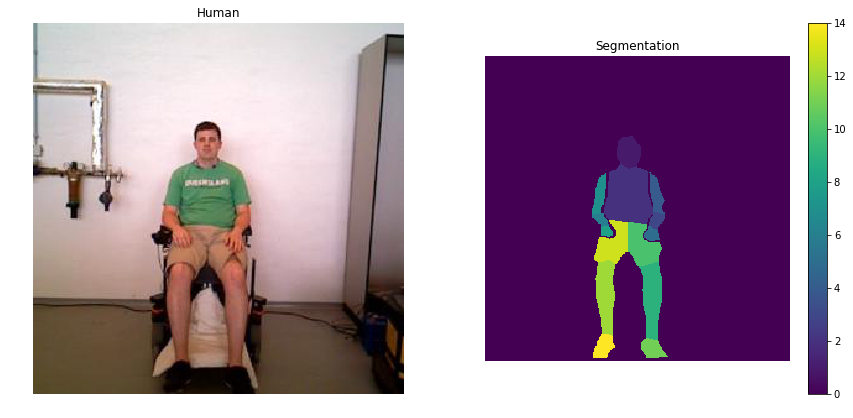

In [10]:
demonstrate_sit = '/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img/image90.jpg'
demonstrate_map_sit = sio.loadmat('/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/masks/image90.mat')['M']

fig = plt.figure(figsize=(15,15))
fig.add_subplot(2, 2, 1)
plt.imshow(plt.imread(demonstrate_sit))
plt.title('Human')
plt.axis("off")
fig.add_subplot(2, 2, 2)
plt.imshow(demonstrate_map_sit)
plt.title('Segmentation')
plt.colorbar()
plt.axis("off");

### Useful functions

In [11]:
def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [12]:
def weighting(image_files, num_classes=25, weight_type='median'):
    """
    The custom class weighing function.
    INPUTS:
    - image_files(list): a list of image_filenames which element can be read immediately;
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label
    and the element is the class weight for that label;
    """
    #initialize dictionary with all 0
    
    label_to_frequency = {}
    
    for i in range(num_classes):
        label_to_frequency[i] = 0
    
    #count frequency of each class for images
    
    for n in range(len(image_files)):
        tmp = image_files[n].split('frame')
        image = sio.loadmat(tmp[0] + '_segm.mat')['segm_' + str(int(tmp[1][0:-4]) + 1)] 
    
        for i in range(num_classes):
            
            class_mask = np.equal(image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            if class_frequency != 0.0:
                label_to_frequency[i]+=(class_frequency)

    
    #applyinf weighting function and appending the class weights to class_weights
    
    class_weights = np.zeros((num_classes))
    
    total_frequency = sum(label_to_frequency.values())
    i = 0
    for class_, freq_ in label_to_frequency.items():
        class_weight = 1 / np.log(1.02 + (freq_ / total_frequency))
        class_weights[i] = class_weight
        i += 1
        
    # as first goes background
    class_weights[0] = 0.0 
    
    return class_weights

### SURREAL Dataset for pre-training.

In [13]:
class SURREALDataset(Dataset):
    def __init__(self, dirry, transforms=None, lengt=None, weights=None, nclasses=True):
        self.pics = []
        
        subdirs = [i[0] for i in os.walk(dirry)]
        
        for i in subdirs:
            for j in [k for k in os.listdir(i) if k.endswith('jpg')]:
                self.pics.append(i + '/' + j)
                if (len(self.pics) > lengt and lengt is not None):
                    break
        
        self.classes = nclasses
        self.transforms = transforms
        if weights is None:
            self.weights = weighting(self.pics, 25)
        else:
            self.weights = weights
            
    def __getitem__(self, i):
        
        num_classes = 25
        
        # get image and add padding to shape (x_height // 32 == 0, x_width // 32 == 0)
        x, pad = load_image(self.pics[i], pad=True)
    
        # get segmentation map
        tmp = self.pics[i].split('frame')
        mask = sio.loadmat(tmp[0] + '_segm.mat')['segm_' + str(int(tmp[1][0:-4]) + 1)]   
        y = np.zeros((num_classes, 256, 320))
        
        for i in range(len(mask)):
            row = mask[i]
            for j in range(len(row)):
                y[row[j], i, j] = 1.0

        # transorm ToTensor + add normalization to zero mean and unit std
        if self.transforms is not None:
            x = self.transforms(x)
        for i in range(0, 3):
            x[i] -= x[i].mean()
            
            x[i] /= x[i].std()
            
        # get all maps or only one
        if self.classes:
            y = torch.FloatTensor(y[1:]) #np.rollaxis(y, 0, 3)
        else:
            y = torch.FloatTensor(y[16].reshape(1, 256, 320)) #np.rollaxis(y, 0, 3)
        
        return x, y
    
    def __len__(self):
        return len(self.pics)
    
    def get_pics_path(self, indx):
        return self.pics[indx]


### Sitting People Dataset.

In [14]:
class SittingDataset(Dataset):
    def __init__(self, dirry, transforms=None, nclasses = True):
        self.pics = []
        for j in tqdm_notebook([k for k in os.listdir(dirry) if k.endswith('jpg')]):
            self.pics.append(dirry + '/' + j)

        self.classes = nclasses
        self.transforms = transforms
    def __getitem__(self, i):
        # get image 
        x = plt.imread(self.pics[i])
        # get segmentation map
        tmp = self.pics[i].split('img')
        mask = sio.loadmat(tmp[0] + 'masks' + tmp[-1][:-4] + '.mat')['M']   
        y = np.zeros((25, 320, 320))
        
        for i in range(len(mask)):
            row = mask[i]
            for j in range(len(row)):
                y[row[j], i, j] = 1.0

        if self.transforms is not None:
            x = self.transforms(x)
       
        for i in range(0, 3):
            x[i] -= x[i].mean()
            
            x[i] /= x[i].std()
    
        if self.classes:
            y = torch.FloatTensor(y[1:3].reshape(24, 320, 320)) #np.rollaxis(y, 0, 3)
        else:
            y = torch.FloatTensor(y[1].reshape(1, 320, 320)) #np.rollaxis(y, 0, 3)
        return x, y
    
    def __len__(self):
        return len(self.pics)

In [15]:
transf = Compose([
    transforms.ToTensor()#,
    #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dset_train = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/train/run0', transf, 10000)
dset_test = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/test/run0', transf, 10000)
dset_val = SURREALDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sur/SURREAL/data/cmu/val/run0', transf, 10000)

### Log

In [16]:
print('Class weights:')
dset_train.weights 

Class weights:


array([ 0.        , 37.3581209 , 40.77333123, 40.89950404, 44.49600152,
       42.81237043, 42.87110293, 44.87940069, 48.54846396, 48.48299106,
       42.73868897, 50.04402807, 50.03096384, 48.92454925, 48.33435856,
       48.52089675, 43.11831745, 46.80357535, 46.88515668, 47.20075103,
       47.25307678, 49.20672423, 49.27367494, 49.69826931, 49.7462459 ])

### Median

In [55]:
print('Class weights:')
dset_train.weights

Class weights:


array([0.        , 0.07387527, 0.10522209, 0.10643649, 0.18536189,
       0.14321454, 0.14530383, 0.17973645, 0.61388611, 0.592284  ,
       0.13119578, 2.84569371, 2.52924079, 0.81576248, 0.64949166,
       0.657062  , 0.14150946, 0.3942852 , 0.37755007, 0.42722958,
       0.40807015, 1.10940423, 1.03242259, 1.87932795, 1.75677862])

In [17]:
train_w = dset_train.weights
test_w = dset_test.weights
val_w = dset_val.weights

In [18]:
batch_sz = 4
train_loader = DataLoader(dset_train, batch_size=batch_sz, shuffle=False)
test_loader = DataLoader(dset_test, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(dset_val, batch_size=batch_sz, shuffle=True)

In [19]:
inputs_sur, classes_sur = next(iter(train_loader))

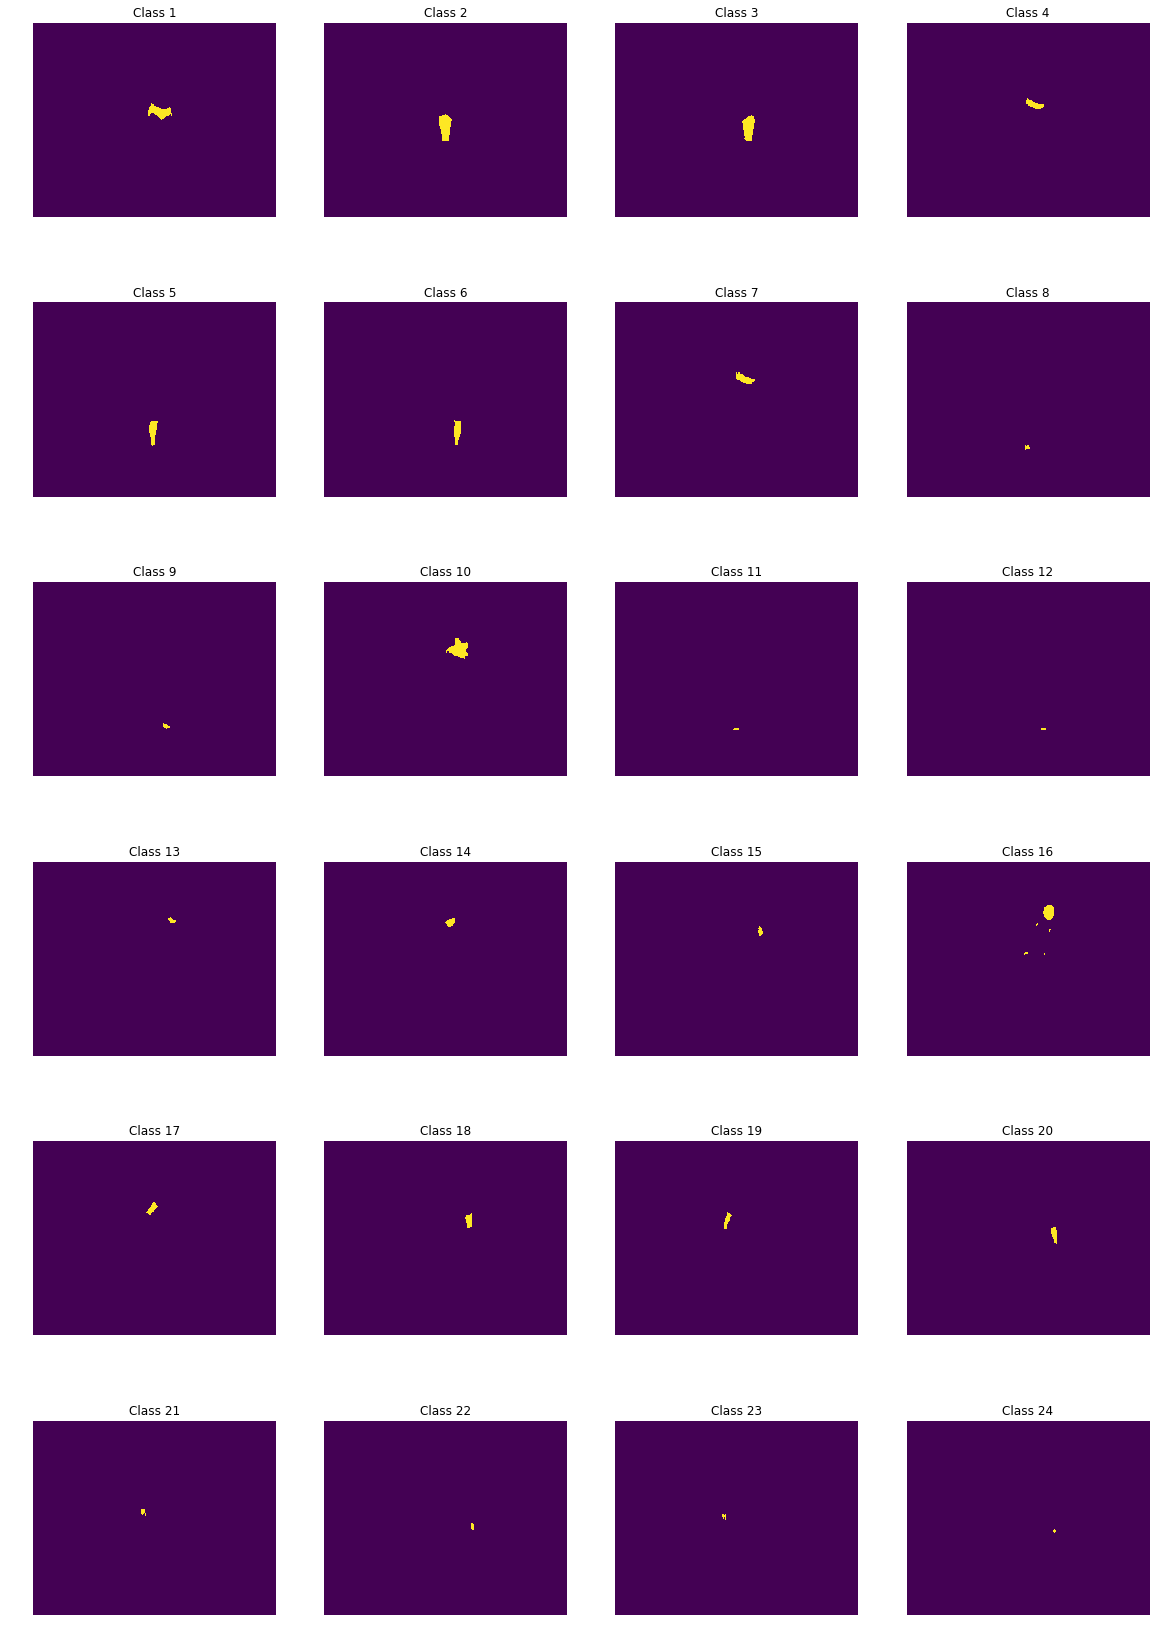

In [20]:
show_pics(classes_sur[0], 4, 6)

In [11]:
dset_sitting = SittingDataset('/home/novikov/data/skoltech/segmentation/SURREAL/data/sitting/img', transf)
sitting_loader = DataLoader(dset_sitting, batch_size=batch_sz, shuffle=True)

HBox(children=(IntProgress(value=0, max=201), HTML(value='')))

In [ ]:
inputs_sit, classes_sit = next(iter(sitting_loader))

In [ ]:
show_pics(classes_sit[0], 4, 6)

## TernausNet

In [22]:
#model from https://github.com/ternaus/TernausNet
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        if pretrained == 'vgg':
            self.encoder = models.vgg11(pretrained=True).features
        else:
            self.encoder = models.vgg11(pretrained=False).features

        
        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 24, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return F.sigmoid(self.final(dec1))


def unet11(pretrained=False, path='', **kwargs):
    model = UNet11(pretrained=pretrained, **kwargs)

    if pretrained == 'carvana':
        state = torch.load('TernausNet.pt')
        model.load_state_dict(state['model'])
    
    if pretrained == 'trained_recently':
        state = torch.load(path)
        model.load_state_dict(state)
    return model

In [23]:
def soft_dice_loss(outputs, targets, weight = 1.0):
    smooth = 1e-15
    iflat = outputs.view(-1)
    tflat = targets.view(-1)
    intersection = (iflat * tflat).sum()
    
    return (1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)))*weight
def weighted_dice_loss(pred, target, weights):
    '''
        pred - (B, C, H, W) real values from [0, 1]
        target - (B, C, H, W) integer values from {0, 1}
        weights - (B, C, H, W) real values from [0, 2],
        1 is a usual pixel, >1 is an important one
    '''
    DICE_SMOOTH = 1e-15
    # the idea is to lower actual intersection in important areas
    inv_weights = 1 / weights[0]
    intersection = pred * inv_weights * target
    
    # the idea is to increase actual predicted values
    # where they have to be zero
    inv_target = 1 - target
    inv_intersection = pred * inv_target * weights[0]
    union = pred + target + inv_intersection

    return 1 - ((2. * intersection.sum() + DICE_SMOOTH) /
                (union.sum() + DICE_SMOOTH))

In [24]:
model = unet11('carvana')

In [25]:
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=1,
    verbose=True,
    threshold=0.1
)

In [26]:
def train(epoch, gpu=False):
    model.train()
    if gpu == True:
        model.cuda()
    loss_tr = []
    
    for batch_idx, (data, target) in (enumerate(train_loader)):
    
        if gpu == True:
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
        
        data, target = torch.unsqueeze(Variable(data), dim=0)[0], Variable(target)
       
        optimizer.zero_grad()
        
# Simple summ of losses:
#         loss_1 = F.binary_cross_entropy(model(data), target)
#         output = model(data)

#         loss_2 = soft_dice_loss(output, target)
#         loss = loss_1 + loss_2
#         loss_tr.append([loss_1.data[0], loss_2.data[0]])
        
# Weighted IoU:
        output = model(data)
        num_cl = target.size(1)
        loss = 0
        for i in range(num_cl):
            loss += soft_dice_loss(output[:, i].resize(target.size(0), 1, 256, 320),
                                   target[:, i].resize(target.size(0), 1, 256, 320),
                                           weight=train_w[i+1])
        loss /= num_cl
        
        # normalize loss to [0,1]
        #loss /= train_w.max()
        
        loss_tr.append(loss.data[0])
        loss.backward()
       
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: WeightIoU {:.7f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    
    return loss_tr

def validate(gpu=False):
    model.eval()
    if gpu == True:
        model.cuda()
    val_loss = []
    
    for batch_idx, (data, target) in (enumerate(val_loader)):
       
        if gpu == True:
            data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
       
        data, target = torch.unsqueeze(Variable(data), dim=0)[0], Variable(target)
        
        optimizer.zero_grad()
        
# Simple summ of losses:
        #loss_1 = F.binary_cross_entropy(model(data), target)
        #loss_2 = soft_dice_loss(model(data), target) 
        output = model(data)
        num_cl = target.size(1)
        loss = 0
        for i in range(num_cl):
            loss += soft_dice_loss(output[:, i].resize(target.size(0), 1, 256, 320),
                                   target[:, i].resize(target.size(0), 1, 256, 320), 
                                 train_w[i+1]/train_w.max())
        loss /= num_cl
        
       
        val_loss.append(loss.data[0])
        #val_loss.append(F.binary_cross_entropy(model(data), target).data[0] + soft_dice_loss(model(data), target).data[0])

    val_loss.append(np.mean(val_loss))
    scheduler.step(val_loss[-1])
    print('Loss on validation:', val_loss[-1])
    return val_loss[-1]

In [ ]:
loss_tr = []
loss_val = []
gpu = torch.cuda.is_available()
for epoch in range(10):
    loss_tr.append(train(epoch, gpu))
    loss_val.append(validate(gpu))
    torch.save(model.state_dict(), 'pytorch_segm_model_sum_loss_2')
torch.save(model.state_dict(), 'pytorch_segm_model_sum_loss_final_2')

Train Epoch: 0 [0/11949 (0%)]	Loss: WeightIoU 46.0285187
Train Epoch: 0 [40/11949 (0%)]	Loss: WeightIoU 46.0755081
Train Epoch: 0 [80/11949 (1%)]	Loss: WeightIoU 46.0364342
Train Epoch: 0 [120/11949 (1%)]	Loss: WeightIoU 45.9901657
Train Epoch: 0 [160/11949 (1%)]	Loss: WeightIoU 45.9300232
Train Epoch: 0 [200/11949 (2%)]	Loss: WeightIoU 46.0885315
Train Epoch: 0 [240/11949 (2%)]	Loss: WeightIoU 46.1050720
Train Epoch: 0 [280/11949 (2%)]	Loss: WeightIoU 46.0123825
Train Epoch: 0 [320/11949 (3%)]	Loss: WeightIoU 45.9352226
Train Epoch: 0 [360/11949 (3%)]	Loss: WeightIoU 45.7617722
Train Epoch: 0 [400/11949 (3%)]	Loss: WeightIoU 45.9610405
Train Epoch: 0 [440/11949 (4%)]	Loss: WeightIoU 45.9464722
Train Epoch: 0 [480/11949 (4%)]	Loss: WeightIoU 45.9127159
Train Epoch: 0 [520/11949 (4%)]	Loss: WeightIoU 45.8952484
Train Epoch: 0 [560/11949 (5%)]	Loss: WeightIoU 45.5901871
Train Epoch: 0 [600/11949 (5%)]	Loss: WeightIoU 45.8228264
Train Epoch: 0 [640/11949 (5%)]	Loss: WeightIoU 45.8176651
T

Train Epoch: 0 [5440/11949 (46%)]	Loss: WeightIoU 43.2822952
Train Epoch: 0 [5480/11949 (46%)]	Loss: WeightIoU 43.3034439
Train Epoch: 0 [5520/11949 (46%)]	Loss: WeightIoU 43.2478943
Train Epoch: 0 [5560/11949 (47%)]	Loss: WeightIoU 43.2124786
Train Epoch: 0 [5600/11949 (47%)]	Loss: WeightIoU 43.2486229
Train Epoch: 0 [5640/11949 (47%)]	Loss: WeightIoU 43.3763046
Train Epoch: 0 [5680/11949 (48%)]	Loss: WeightIoU 43.1040306
Train Epoch: 0 [5720/11949 (48%)]	Loss: WeightIoU 43.1899948
Train Epoch: 0 [5760/11949 (48%)]	Loss: WeightIoU 43.3283463
Train Epoch: 0 [5800/11949 (49%)]	Loss: WeightIoU 43.1834221
Train Epoch: 0 [5840/11949 (49%)]	Loss: WeightIoU 43.2372894
Train Epoch: 0 [5880/11949 (49%)]	Loss: WeightIoU 43.3186646
Train Epoch: 0 [5920/11949 (50%)]	Loss: WeightIoU 43.1823807
Train Epoch: 0 [5960/11949 (50%)]	Loss: WeightIoU 43.1934929
Train Epoch: 0 [6000/11949 (50%)]	Loss: WeightIoU 43.1122589
Train Epoch: 0 [6040/11949 (51%)]	Loss: WeightIoU 43.1135101
Train Epoch: 0 [6080/119

Train Epoch: 0 [10800/11949 (90%)]	Loss: WeightIoU 41.2766571
Train Epoch: 0 [10840/11949 (91%)]	Loss: WeightIoU 42.2123566
Train Epoch: 0 [10880/11949 (91%)]	Loss: WeightIoU 42.0422859
Train Epoch: 0 [10920/11949 (91%)]	Loss: WeightIoU 41.6994133
Train Epoch: 0 [10960/11949 (92%)]	Loss: WeightIoU 41.4766121
Train Epoch: 0 [11000/11949 (92%)]	Loss: WeightIoU 41.6377144
Train Epoch: 0 [11040/11949 (92%)]	Loss: WeightIoU 40.8320732
Train Epoch: 0 [11080/11949 (93%)]	Loss: WeightIoU 41.4938583
Train Epoch: 0 [11120/11949 (93%)]	Loss: WeightIoU 40.9292526
Train Epoch: 0 [11160/11949 (93%)]	Loss: WeightIoU 41.2309227
Train Epoch: 0 [11200/11949 (94%)]	Loss: WeightIoU 41.5292435
Train Epoch: 0 [11240/11949 (94%)]	Loss: WeightIoU 41.4538422
Train Epoch: 0 [11280/11949 (94%)]	Loss: WeightIoU 41.8448410
Train Epoch: 0 [11320/11949 (95%)]	Loss: WeightIoU 40.9712372
Train Epoch: 0 [11360/11949 (95%)]	Loss: WeightIoU 40.9796791
Train Epoch: 0 [11400/11949 (95%)]	Loss: WeightIoU 41.3267288
Train Ep

Train Epoch: 1 [4240/11949 (35%)]	Loss: WeightIoU 39.2320900
Train Epoch: 1 [4280/11949 (36%)]	Loss: WeightIoU 40.1667366
Train Epoch: 1 [4320/11949 (36%)]	Loss: WeightIoU 39.2894745
Train Epoch: 1 [4360/11949 (36%)]	Loss: WeightIoU 40.3275375
Train Epoch: 1 [4400/11949 (37%)]	Loss: WeightIoU 39.9199753
Train Epoch: 1 [4440/11949 (37%)]	Loss: WeightIoU 40.2649040
Train Epoch: 1 [4480/11949 (37%)]	Loss: WeightIoU 40.2331772
Train Epoch: 1 [4520/11949 (38%)]	Loss: WeightIoU 39.4824295
Train Epoch: 1 [4560/11949 (38%)]	Loss: WeightIoU 40.4708290
Train Epoch: 1 [4600/11949 (38%)]	Loss: WeightIoU 39.9116211
Train Epoch: 1 [4640/11949 (39%)]	Loss: WeightIoU 39.7891884
Train Epoch: 1 [4680/11949 (39%)]	Loss: WeightIoU 39.4861450
Train Epoch: 1 [4720/11949 (39%)]	Loss: WeightIoU 39.9329758
Train Epoch: 1 [4760/11949 (40%)]	Loss: WeightIoU 39.5636559
Train Epoch: 1 [4800/11949 (40%)]	Loss: WeightIoU 39.7958031
Train Epoch: 1 [4840/11949 (40%)]	Loss: WeightIoU 39.5202408
Train Epoch: 1 [4880/119

Train Epoch: 1 [9640/11949 (81%)]	Loss: WeightIoU 39.0018501
Train Epoch: 1 [9680/11949 (81%)]	Loss: WeightIoU 38.6534615
Train Epoch: 1 [9720/11949 (81%)]	Loss: WeightIoU 38.8153496
Train Epoch: 1 [9760/11949 (82%)]	Loss: WeightIoU 39.3416481
Train Epoch: 1 [9800/11949 (82%)]	Loss: WeightIoU 38.5461006
Train Epoch: 1 [9840/11949 (82%)]	Loss: WeightIoU 38.6541519
Train Epoch: 1 [9880/11949 (83%)]	Loss: WeightIoU 38.8852959
Train Epoch: 1 [9920/11949 (83%)]	Loss: WeightIoU 38.5246696
Train Epoch: 1 [9960/11949 (83%)]	Loss: WeightIoU 38.7713165
Train Epoch: 1 [10000/11949 (84%)]	Loss: WeightIoU 39.0882988
Train Epoch: 1 [10040/11949 (84%)]	Loss: WeightIoU 41.6233521
Train Epoch: 1 [10080/11949 (84%)]	Loss: WeightIoU 41.8205795
Train Epoch: 1 [10120/11949 (85%)]	Loss: WeightIoU 40.1673546
Train Epoch: 1 [10160/11949 (85%)]	Loss: WeightIoU 39.4847946
Train Epoch: 1 [10200/11949 (85%)]	Loss: WeightIoU 39.2125320
Train Epoch: 1 [10240/11949 (86%)]	Loss: WeightIoU 40.9702225
Train Epoch: 1 [1

Train Epoch: 2 [3040/11949 (25%)]	Loss: WeightIoU 36.5533066
Train Epoch: 2 [3080/11949 (26%)]	Loss: WeightIoU 36.1166992
Train Epoch: 2 [3120/11949 (26%)]	Loss: WeightIoU 37.0640945
Train Epoch: 2 [3160/11949 (26%)]	Loss: WeightIoU 36.7422180
Train Epoch: 2 [3200/11949 (27%)]	Loss: WeightIoU 35.5888596
Train Epoch: 2 [3240/11949 (27%)]	Loss: WeightIoU 34.4779129
Train Epoch: 2 [3280/11949 (27%)]	Loss: WeightIoU 36.7953529
Train Epoch: 2 [3320/11949 (28%)]	Loss: WeightIoU 35.6616631
Train Epoch: 2 [3360/11949 (28%)]	Loss: WeightIoU 35.4729576
Train Epoch: 2 [3400/11949 (28%)]	Loss: WeightIoU 37.2046661
Train Epoch: 2 [3440/11949 (29%)]	Loss: WeightIoU 35.8286133
Train Epoch: 2 [3480/11949 (29%)]	Loss: WeightIoU 34.8046188
Train Epoch: 2 [3520/11949 (29%)]	Loss: WeightIoU 34.9550743
Train Epoch: 2 [3560/11949 (30%)]	Loss: WeightIoU 34.6412125
Train Epoch: 2 [3600/11949 (30%)]	Loss: WeightIoU 34.4834747
Train Epoch: 2 [3640/11949 (30%)]	Loss: WeightIoU 33.8821030
Train Epoch: 2 [3680/119

Train Epoch: 2 [8440/11949 (71%)]	Loss: WeightIoU 31.9586620
Train Epoch: 2 [8480/11949 (71%)]	Loss: WeightIoU 32.5745010
Train Epoch: 2 [8520/11949 (71%)]	Loss: WeightIoU 31.6346493
Train Epoch: 2 [8560/11949 (72%)]	Loss: WeightIoU 31.5101852
Train Epoch: 2 [8600/11949 (72%)]	Loss: WeightIoU 31.2482681
Train Epoch: 2 [8640/11949 (72%)]	Loss: WeightIoU 32.1198997
Train Epoch: 2 [8680/11949 (73%)]	Loss: WeightIoU 32.1951408
Train Epoch: 2 [8720/11949 (73%)]	Loss: WeightIoU 35.6700668
Train Epoch: 2 [8760/11949 (73%)]	Loss: WeightIoU 32.5812912
Train Epoch: 2 [8800/11949 (74%)]	Loss: WeightIoU 32.7746277
Train Epoch: 2 [8840/11949 (74%)]	Loss: WeightIoU 33.3580551
Train Epoch: 2 [8880/11949 (74%)]	Loss: WeightIoU 33.0373344
Train Epoch: 2 [8920/11949 (75%)]	Loss: WeightIoU 31.8675289
Train Epoch: 2 [8960/11949 (75%)]	Loss: WeightIoU 32.6141357
Train Epoch: 2 [9000/11949 (75%)]	Loss: WeightIoU 33.0120239
Train Epoch: 2 [9040/11949 (76%)]	Loss: WeightIoU 33.6220131
Train Epoch: 2 [9080/119

Train Epoch: 3 [1840/11949 (15%)]	Loss: WeightIoU 25.7242699
Train Epoch: 3 [1880/11949 (16%)]	Loss: WeightIoU 29.7224617
Train Epoch: 3 [1920/11949 (16%)]	Loss: WeightIoU 26.7094707
Train Epoch: 3 [1960/11949 (16%)]	Loss: WeightIoU 26.5828304
Train Epoch: 3 [2000/11949 (17%)]	Loss: WeightIoU 26.6078072
Train Epoch: 3 [2040/11949 (17%)]	Loss: WeightIoU 26.1839638
Train Epoch: 3 [2080/11949 (17%)]	Loss: WeightIoU 26.4084625
Train Epoch: 3 [2120/11949 (18%)]	Loss: WeightIoU 27.4036255
Train Epoch: 3 [2160/11949 (18%)]	Loss: WeightIoU 27.3202972
Train Epoch: 3 [2200/11949 (18%)]	Loss: WeightIoU 26.0821972
Train Epoch: 3 [2240/11949 (19%)]	Loss: WeightIoU 28.6735725
Train Epoch: 3 [2280/11949 (19%)]	Loss: WeightIoU 23.9959145
Train Epoch: 3 [2320/11949 (19%)]	Loss: WeightIoU 23.3907604
Train Epoch: 3 [2360/11949 (20%)]	Loss: WeightIoU 27.1417389
Train Epoch: 3 [2400/11949 (20%)]	Loss: WeightIoU 24.6234283
Train Epoch: 3 [2440/11949 (20%)]	Loss: WeightIoU 24.0282059
Train Epoch: 3 [2480/119

Train Epoch: 3 [7240/11949 (61%)]	Loss: WeightIoU 30.3623867
Train Epoch: 3 [7280/11949 (61%)]	Loss: WeightIoU 25.6345711
Train Epoch: 3 [7320/11949 (61%)]	Loss: WeightIoU 27.2387199
Train Epoch: 3 [7360/11949 (62%)]	Loss: WeightIoU 29.6125603
Train Epoch: 3 [7400/11949 (62%)]	Loss: WeightIoU 24.8515015
Train Epoch: 3 [7440/11949 (62%)]	Loss: WeightIoU 24.3011360
Train Epoch: 3 [7480/11949 (63%)]	Loss: WeightIoU 23.2083092
Train Epoch: 3 [7520/11949 (63%)]	Loss: WeightIoU 22.6069622
Train Epoch: 3 [7560/11949 (63%)]	Loss: WeightIoU 28.5971813
Train Epoch: 3 [7600/11949 (64%)]	Loss: WeightIoU 28.0953827
Train Epoch: 3 [7640/11949 (64%)]	Loss: WeightIoU 25.7279053
Train Epoch: 3 [7680/11949 (64%)]	Loss: WeightIoU 20.7935028
Train Epoch: 3 [7720/11949 (65%)]	Loss: WeightIoU 25.0730324
Train Epoch: 3 [7760/11949 (65%)]	Loss: WeightIoU 20.4518566
Train Epoch: 3 [7800/11949 (65%)]	Loss: WeightIoU 22.3301353
Train Epoch: 3 [7840/11949 (66%)]	Loss: WeightIoU 21.4794598
Train Epoch: 3 [7880/119

Train Epoch: 4 [640/11949 (5%)]	Loss: WeightIoU 20.1130219
Train Epoch: 4 [680/11949 (6%)]	Loss: WeightIoU 27.4986649
Train Epoch: 4 [720/11949 (6%)]	Loss: WeightIoU 28.6893272
Train Epoch: 4 [760/11949 (6%)]	Loss: WeightIoU 22.6361504
Train Epoch: 4 [800/11949 (7%)]	Loss: WeightIoU 22.7158260
Train Epoch: 4 [840/11949 (7%)]	Loss: WeightIoU 25.4665604
Train Epoch: 4 [880/11949 (7%)]	Loss: WeightIoU 23.0988750
Train Epoch: 4 [920/11949 (8%)]	Loss: WeightIoU 21.1385040
Train Epoch: 4 [960/11949 (8%)]	Loss: WeightIoU 22.6676674
Train Epoch: 4 [1000/11949 (8%)]	Loss: WeightIoU 22.4321823
Train Epoch: 4 [1040/11949 (9%)]	Loss: WeightIoU 22.2879162
Train Epoch: 4 [1080/11949 (9%)]	Loss: WeightIoU 19.4596081
Train Epoch: 4 [1120/11949 (9%)]	Loss: WeightIoU 21.5636578
Train Epoch: 4 [1160/11949 (10%)]	Loss: WeightIoU 19.0475845
Train Epoch: 4 [1200/11949 (10%)]	Loss: WeightIoU 22.7400036
Train Epoch: 4 [1240/11949 (10%)]	Loss: WeightIoU 20.3677406
Train Epoch: 4 [1280/11949 (11%)]	Loss: Weight

Train Epoch: 4 [6040/11949 (51%)]	Loss: WeightIoU 18.6933975
Train Epoch: 4 [6080/11949 (51%)]	Loss: WeightIoU 23.3598003
Train Epoch: 4 [6120/11949 (51%)]	Loss: WeightIoU 25.0569668
Train Epoch: 4 [6160/11949 (52%)]	Loss: WeightIoU 20.9699173
Train Epoch: 4 [6200/11949 (52%)]	Loss: WeightIoU 20.6903572
Train Epoch: 4 [6240/11949 (52%)]	Loss: WeightIoU 19.5308590
Train Epoch: 4 [6280/11949 (53%)]	Loss: WeightIoU 22.7127724
Train Epoch: 4 [6320/11949 (53%)]	Loss: WeightIoU 22.2855644
Train Epoch: 4 [6360/11949 (53%)]	Loss: WeightIoU 21.0159073
Train Epoch: 4 [6400/11949 (54%)]	Loss: WeightIoU 20.1817398
Train Epoch: 4 [6440/11949 (54%)]	Loss: WeightIoU 19.2827511
Train Epoch: 4 [6480/11949 (54%)]	Loss: WeightIoU 20.9818382
Train Epoch: 4 [6520/11949 (55%)]	Loss: WeightIoU 25.8858948
Train Epoch: 4 [6560/11949 (55%)]	Loss: WeightIoU 23.7975159
Train Epoch: 4 [6600/11949 (55%)]	Loss: WeightIoU 23.4160824
Train Epoch: 4 [6640/11949 (56%)]	Loss: WeightIoU 18.5773182
Train Epoch: 4 [6680/119

Train Epoch: 4 [11400/11949 (95%)]	Loss: WeightIoU 28.3940849
Train Epoch: 4 [11440/11949 (96%)]	Loss: WeightIoU 27.0314255
Train Epoch: 4 [11480/11949 (96%)]	Loss: WeightIoU 28.8965607
Train Epoch: 4 [11520/11949 (96%)]	Loss: WeightIoU 30.3664913
Train Epoch: 4 [11560/11949 (97%)]	Loss: WeightIoU 27.4844513
Train Epoch: 4 [11600/11949 (97%)]	Loss: WeightIoU 26.6118851
Train Epoch: 4 [11640/11949 (97%)]	Loss: WeightIoU 35.3629112
Train Epoch: 4 [11680/11949 (98%)]	Loss: WeightIoU 28.0945873
Train Epoch: 4 [11720/11949 (98%)]	Loss: WeightIoU 24.7297478
Train Epoch: 4 [11760/11949 (98%)]	Loss: WeightIoU 26.2830505
Train Epoch: 4 [11800/11949 (99%)]	Loss: WeightIoU 29.2861996
Train Epoch: 4 [11840/11949 (99%)]	Loss: WeightIoU 24.0691185
Train Epoch: 4 [11880/11949 (99%)]	Loss: WeightIoU 31.3463440
Train Epoch: 4 [11920/11949 (100%)]	Loss: WeightIoU 32.8078156
Loss on validation: 0.5717998825617738
Train Epoch: 5 [0/11949 (0%)]	Loss: WeightIoU 21.3307724
Train Epoch: 5 [40/11949 (0%)]	Loss

Train Epoch: 5 [4840/11949 (40%)]	Loss: WeightIoU 19.2074432
Train Epoch: 5 [4880/11949 (41%)]	Loss: WeightIoU 20.3754959
Train Epoch: 5 [4920/11949 (41%)]	Loss: WeightIoU 24.9558907
Train Epoch: 5 [4960/11949 (41%)]	Loss: WeightIoU 21.7466812
Train Epoch: 5 [5000/11949 (42%)]	Loss: WeightIoU 22.1030121
Train Epoch: 5 [5040/11949 (42%)]	Loss: WeightIoU 21.3385162
Train Epoch: 5 [5080/11949 (43%)]	Loss: WeightIoU 25.6791210
Train Epoch: 5 [5120/11949 (43%)]	Loss: WeightIoU 20.6039219
Train Epoch: 5 [5160/11949 (43%)]	Loss: WeightIoU 20.8046722
Train Epoch: 5 [5200/11949 (44%)]	Loss: WeightIoU 18.6845284
Train Epoch: 5 [5240/11949 (44%)]	Loss: WeightIoU 18.7513046
Train Epoch: 5 [5280/11949 (44%)]	Loss: WeightIoU 22.7561951
Train Epoch: 5 [5320/11949 (45%)]	Loss: WeightIoU 26.1475677
Train Epoch: 5 [5360/11949 (45%)]	Loss: WeightIoU 18.8789940
Train Epoch: 5 [5400/11949 (45%)]	Loss: WeightIoU 19.4657745
Train Epoch: 5 [5440/11949 (46%)]	Loss: WeightIoU 18.2869129
Train Epoch: 5 [5480/119

Train Epoch: 5 [10240/11949 (86%)]	Loss: WeightIoU 27.5774727
Train Epoch: 5 [10280/11949 (86%)]	Loss: WeightIoU 26.0464306
Train Epoch: 5 [10320/11949 (86%)]	Loss: WeightIoU 27.5914421
Train Epoch: 5 [10360/11949 (87%)]	Loss: WeightIoU 23.8572197
Train Epoch: 5 [10400/11949 (87%)]	Loss: WeightIoU 27.3933067
Train Epoch: 5 [10440/11949 (87%)]	Loss: WeightIoU 24.1284237
Train Epoch: 5 [10480/11949 (88%)]	Loss: WeightIoU 30.1931725
Train Epoch: 5 [10520/11949 (88%)]	Loss: WeightIoU 28.4134579
Train Epoch: 5 [10560/11949 (88%)]	Loss: WeightIoU 28.4327755
Train Epoch: 5 [10600/11949 (89%)]	Loss: WeightIoU 27.6003609
Train Epoch: 5 [10640/11949 (89%)]	Loss: WeightIoU 33.1647873
Train Epoch: 5 [10680/11949 (89%)]	Loss: WeightIoU 30.2151623
Train Epoch: 5 [10720/11949 (90%)]	Loss: WeightIoU 30.7675095
Train Epoch: 5 [10760/11949 (90%)]	Loss: WeightIoU 26.6787987
Train Epoch: 5 [10800/11949 (90%)]	Loss: WeightIoU 27.8856640
Train Epoch: 5 [10840/11949 (91%)]	Loss: WeightIoU 30.3515816
Train Ep

### Loss story:

## Check the results.

In [27]:
model = unet11('trained_recently', path= 'pytorch_segm_model_sum_loss_2')

In [28]:
inputs, classes = next(iter(train_loader))
input_img = torch.unsqueeze(Variable(inputs.cuda(async=True)), dim=0)[0]
model.cuda()
model.eval()
output = model(input_img).data.cpu().numpy()

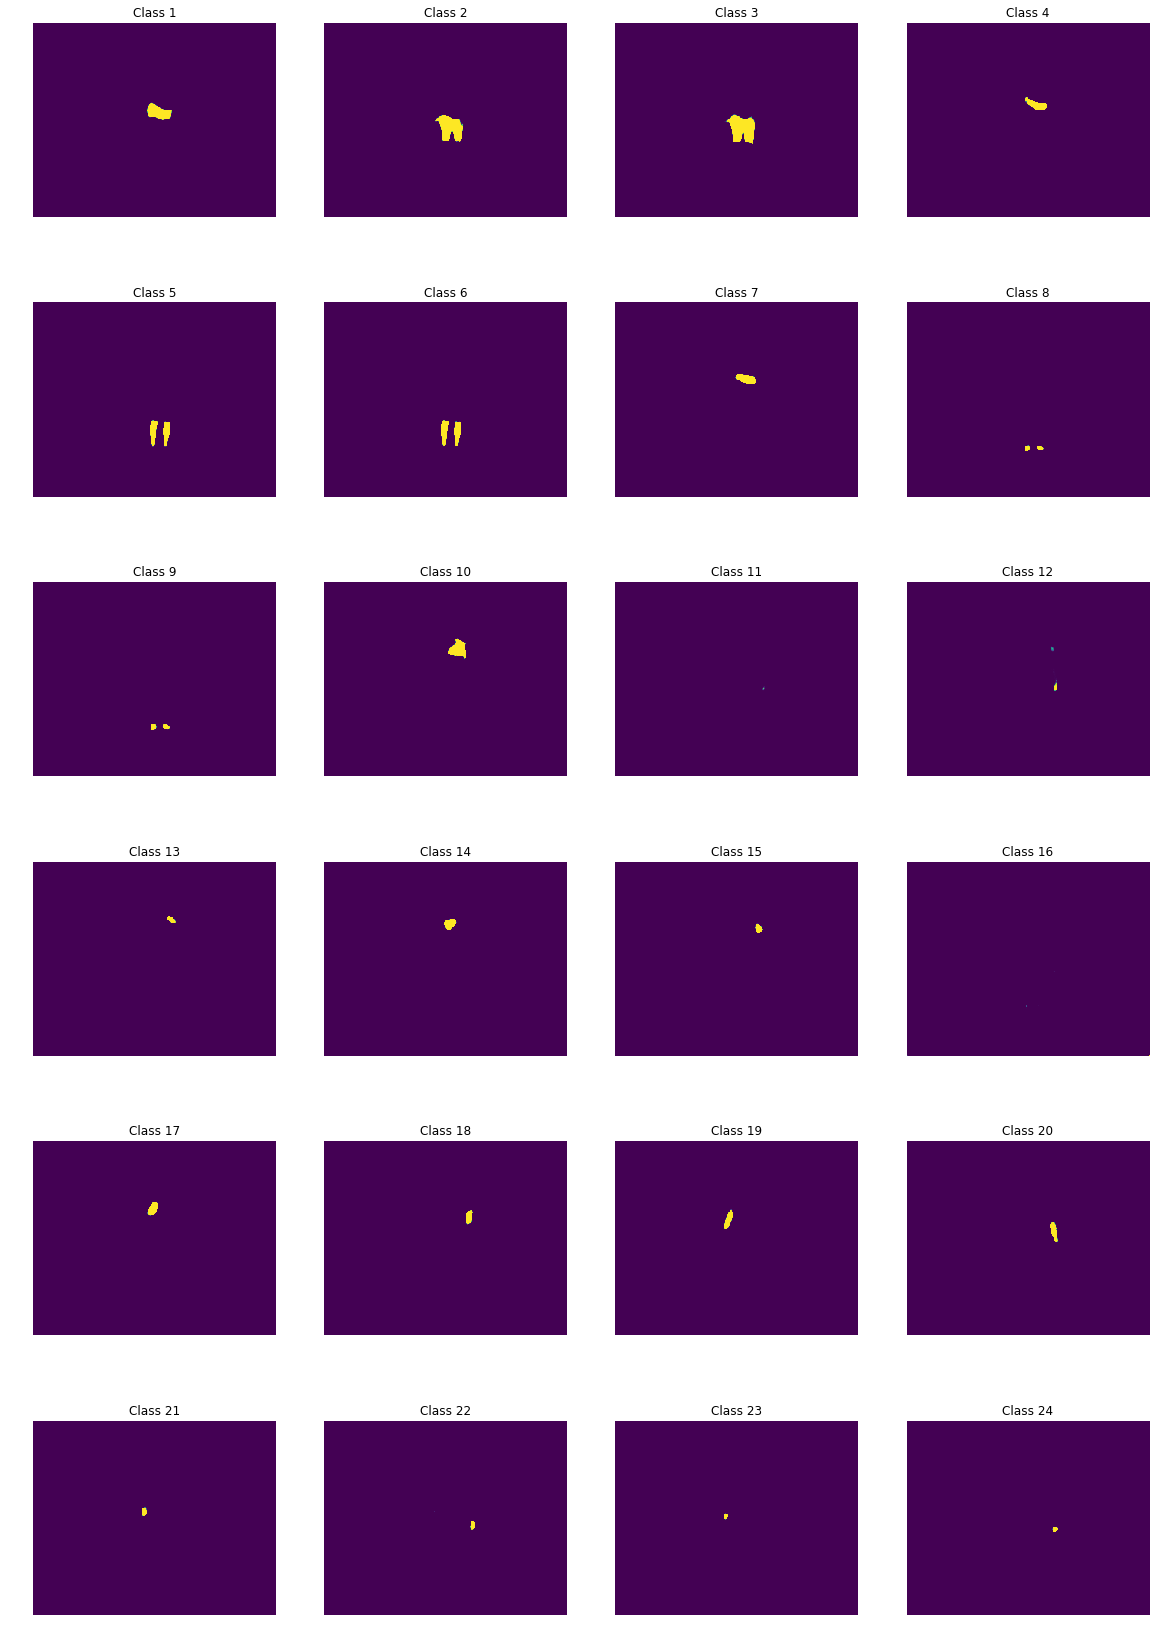

In [29]:
show_pics(output[0], 4, 6)

In [ ]:
tmp_2 = classes.numpy()

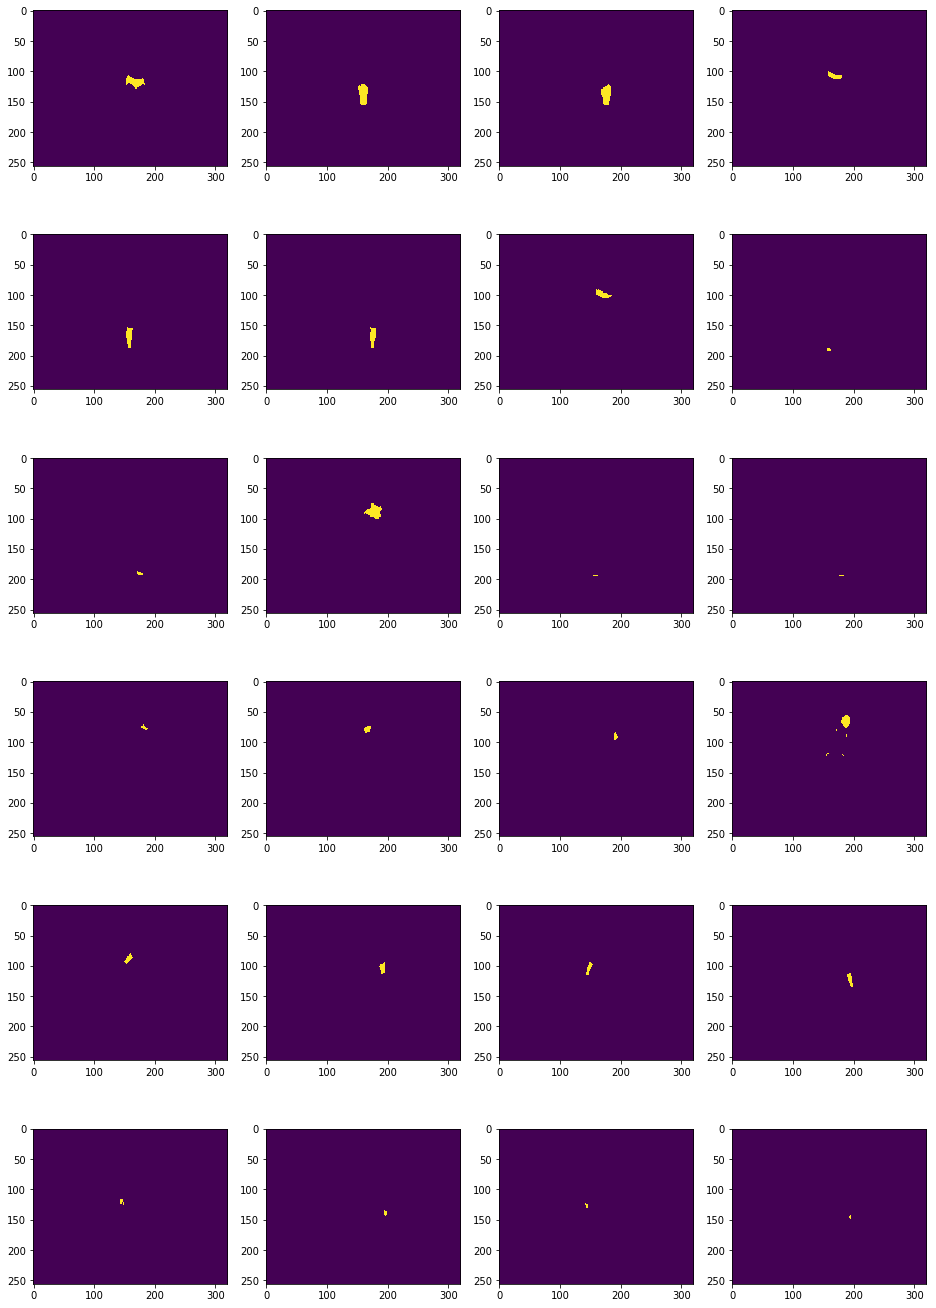

In [21]:
show_pics(tmp_2[0], 4, 6)

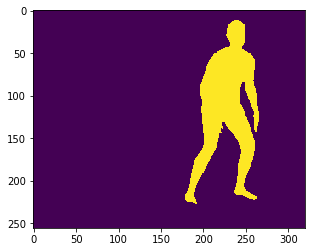

In [27]:
plt.imshow(np.sum(tmp_2[0], axis=0))